# Dataset 2B Hotel

Nama: Nixon\
NIM: 2702248420

In [1]:
import pandas as pd
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import streamlit as st

##### Global Function

In [2]:
def CheckNull(df, columnName):
     print(columnName, ": ", df[columnName].isnull().sum())

def CheckSkewness(df, columnName):
     skewness = df[columnName].skew()
     print(f"Skewness: {skewness}")
     if skewness > 0:
          print("Distribusi miring ke kanan (positif)")
     elif skewness < 0:
          print("Distribusi miring ke kiri (negatif)")
     else:
          print("Distribusi simetris / normal")

def CheckOutlier(df, numerical_cols):
     plt.figure(figsize=(15, 6))

     sns.boxplot(data=df[numerical_cols], orient='h')

     plt.title('Boxplot untuk Semua Kolom Numerik')
     plt.xlabel('Nilai')
     plt.tight_layout()
     plt.show()

### EDA

In [3]:
df = pd.read_csv("Dataset_B_hotel.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     35368 non-null  object 
 6   required_car_parking_space            35005 non-null  float64
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [4]:
for i in list(df.columns):
    CheckNull(df, i)

Booking_ID :  0
no_of_adults :  0
no_of_children :  0
no_of_weekend_nights :  0
no_of_week_nights :  0
type_of_meal_plan :  907
required_car_parking_space :  1270
room_type_reserved :  0
lead_time :  0
arrival_year :  0
arrival_month :  0
arrival_date :  0
market_segment_type :  0
repeated_guest :  0
no_of_previous_cancellations :  0
no_of_previous_bookings_not_canceled :  0
avg_price_per_room :  1632
no_of_special_requests :  0
booking_status :  0


Jika kita melihat hasil dari 'df', maka kita bisa melihat bahwa ada beberapa column yang berisi nilai null, seperti 'type_of_meal_plan', 'required_car_parking_space', dan 'avg_price_per_rroom'

#### NULL Handling

#### a. type_of_meal_plan

In [5]:
df['type_of_meal_plan'].unique()

array(['Meal Plan 1', 'Not Selected', 'Meal Plan 2', nan, 'Meal Plan 3'],
      dtype=object)

Dalam 'type_of_meal_plan', terdapat column yang berisi 'Not selected', kita bisa saja mengisi nilai NULL sesuai dengan mean atau modus, tapi karena kolom ini bersifat categorical, dan secara logika mereka yang tidak mengisi kolom itu kemungkinan besar tidak memesan meal nya, maka lebih baik kita mengisi nya dengan 'Not selected'

In [6]:
df['type_of_meal_plan'] = df['type_of_meal_plan'].fillna('Not Selected')

In [7]:
CheckNull(df, 'type_of_meal_plan')

type_of_meal_plan :  0


#### b. required_car_parking_space

In [8]:
df['required_car_parking_space'].unique()

array([ 0., nan,  1.])

'required_car_parking_space' adalah kolom yang menjelaskan apakah pelanggan membutuhkan tempat parkir, jika '0' artinya tidak, jika '1' artinya iya, maka dari itu nilai NULL bisa kita ubah ke dalam '0' karena kemungkinan mereka yang bernilai NULL tidak membutuhkan tempat parkir

In [9]:
df['required_car_parking_space'] = df['required_car_parking_space'].fillna(0)

In [10]:
CheckNull(df, 'required_car_parking_space')

required_car_parking_space :  0


#### c. avg_price_per_room

In [11]:
df['avg_price_per_room'].unique()

array([ 65.  , 106.68,  60.  , ..., 118.43, 137.25, 167.8 ])

In [12]:
CheckSkewness(df, 'avg_price_per_room')

Skewness: 0.6654046613647858
Distribusi miring ke kanan (positif)


In [13]:
df['avg_price_per_room'] = df['avg_price_per_room'].fillna(df['avg_price_per_room'].median())

Karena kita melihat datanya ada skewness, maka kita bisa menggunakan median untuk mengisi nilai NA nya

In [14]:
CheckNull(df, 'avg_price_per_room')

avg_price_per_room :  0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  float64
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

Semua data sudah tidak ada yang isi nya null lagi

#### Outlier Check

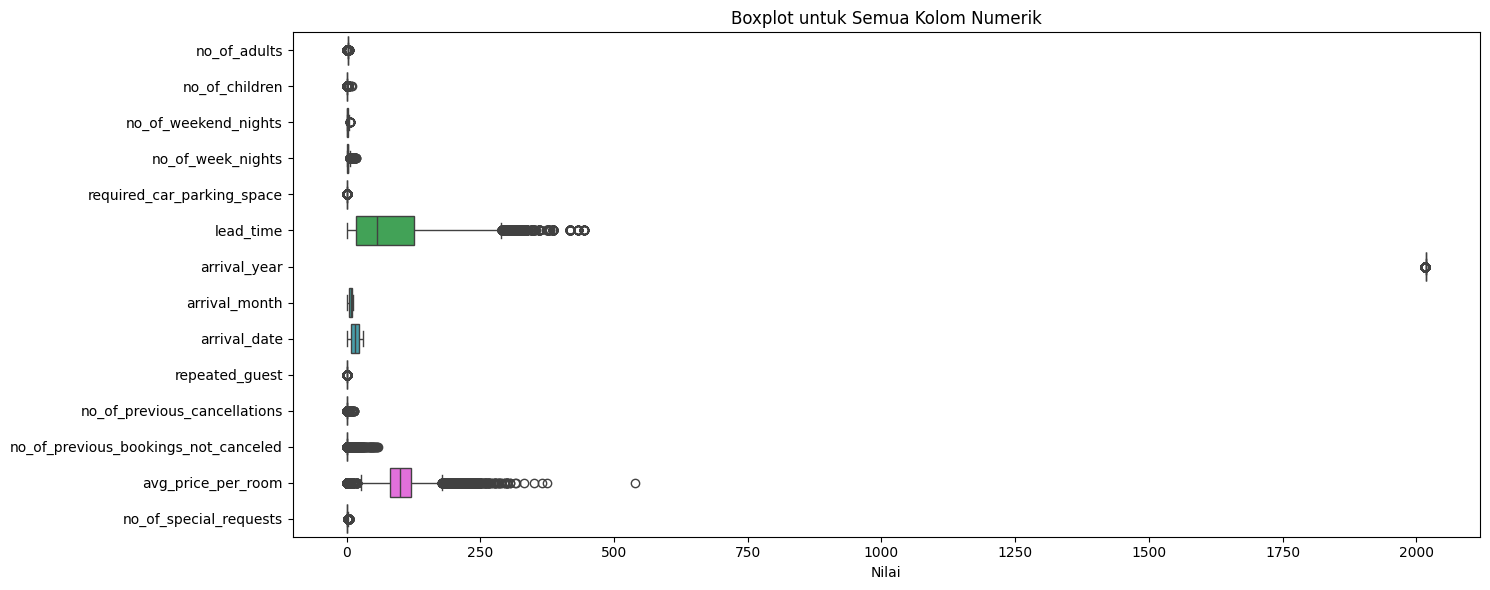

In [16]:
numerical_cols = df.select_dtypes(include=['number']).columns

CheckOutlier(df, numerical_cols)

In [17]:
scaler = RobustScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

Karena semua nilai yang outlier adalah data yang digunakan, maka kita tidak bisa menghapus semua nilai outlier, maka dari itu kita bisa meng-handle nya dengan scaling, menggunakan RoubustScaler

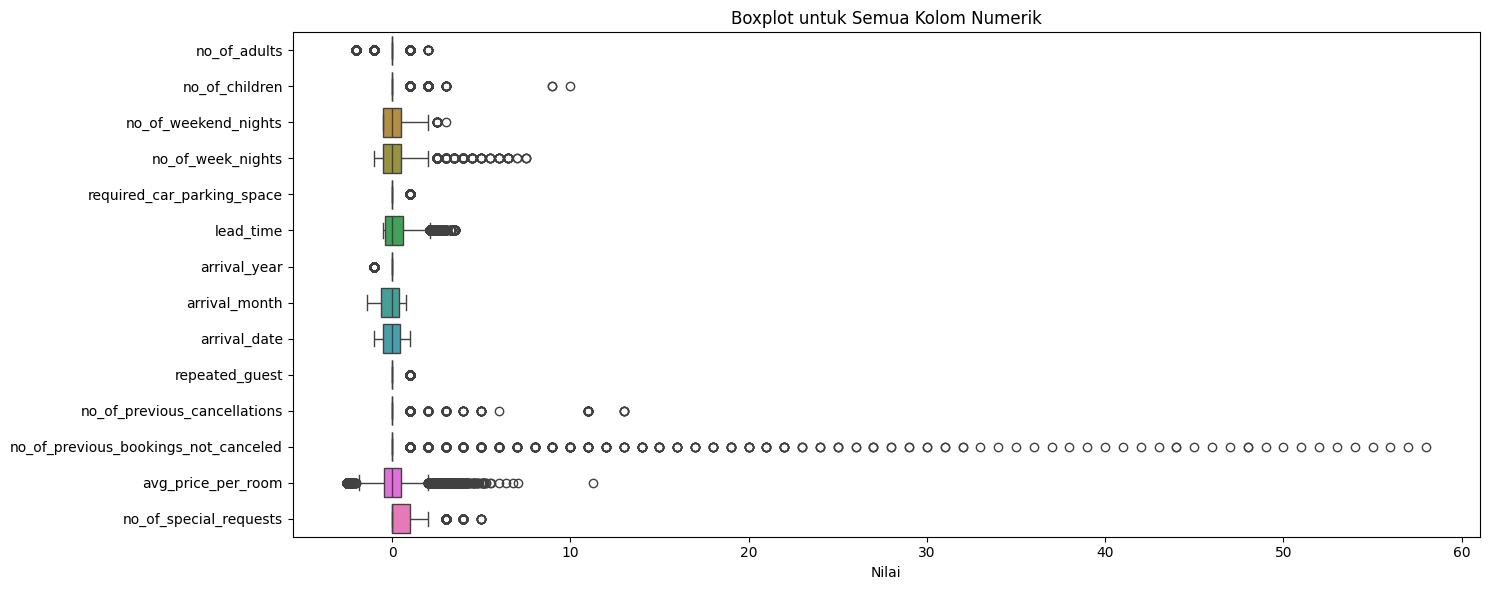

In [18]:
CheckOutlier(df, numerical_cols)

#### Encoding

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  float64
 2   no_of_children                        36275 non-null  float64
 3   no_of_weekend_nights                  36275 non-null  float64
 4   no_of_week_nights                     36275 non-null  float64
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  float64
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  float64
 9   arrival_year                          36275 non-null  float64
 10  arrival_month                         36275 non-null  float64
 11  arrival_date   

##### a. type_of_meal_plan

In [20]:
df['type_of_meal_plan'].unique()

array(['Meal Plan 1', 'Not Selected', 'Meal Plan 2', 'Meal Plan 3'],
      dtype=object)

In [21]:
mapping = {
    'Not Selected': 0,
    'Meal Plan 1': 1,
    'Meal Plan 2': 2,
    'Meal Plan 3': 3
}

df['type_of_meal_plan'] = df['type_of_meal_plan'].map(mapping)

kolom 'type_of_meal_plan' adalah categorical, dimana kita mau mapping menjadi tipe numerical, maka kita kita bisa mapping menjadi numerical

In [22]:
df['type_of_meal_plan'].unique()

array([1, 0, 2, 3])

In [41]:
meal_plan_mapping = {
    'Not Selected': 0,
    'Meal Plan 1': 1,
    'Meal Plan 2': 2,
    'Meal Plan 3': 3
}

with open('meal_plan_mapping.pkl', 'wb') as f:
    pickle.dump(meal_plan_mapping, f)

##### b. room_type_reserved

In [23]:
df['room_type_reserved'].unique()

array(['Room_Type 1', 'Room_Type 4', 'Room_Type 2', 'Room_Type 6',
       'Room_Type 5', 'Room_Type 7', 'Room_Type 3'], dtype=object)

In [24]:
mapping = {
    'Room_Type 1': 1,
    'Room_Type 2': 2,
    'Room_Type 3': 3,
    'Room_Type 4': 4,
    'Room_Type 5': 5,
    'Room_Type 6': 6,
    'Room_Type 7': 7
}

df['room_type_reserved'] = df['room_type_reserved'].map(mapping)

In [25]:
df['room_type_reserved'].unique()

array([1, 4, 2, 6, 5, 7, 3])

In [42]:
room_type_mapping = {
    'Room_Type 1': 1,
    'Room_Type 2': 2,
    'Room_Type 3': 3,
    'Room_Type 4': 4,
    'Room_Type 5': 5,
    'Room_Type 6': 6,
    'Room_Type 7': 7
}

with open('room_type_mapping.pkl', 'wb') as f:
    pickle.dump(room_type_mapping, f)

##### c. market_segment_type

In [26]:
df['market_segment_type'].unique()

array(['Offline', 'Online', 'Corporate', 'Aviation', 'Complementary'],
      dtype=object)

In [27]:
mapping = {
    'Offline': 1,
    'Online': 2,
    'Corporate': 3,
    'Aviation': 4,
    'Complementary': 5,
}

df['market_segment_type'] = df['market_segment_type'].map(mapping)

In [28]:
df['market_segment_type'].unique()

array([1, 2, 3, 4, 5])

In [43]:
market_segment_mapping = {
    'Room_Type 1': 1,
    'Room_Type 2': 2,
    'Room_Type 3': 3,
    'Room_Type 4': 4,
    'Room_Type 5': 5,
    'Room_Type 6': 6,
    'Room_Type 7': 7
}

with open('market_segment_mapping.pkl', 'wb') as f:
    pickle.dump(market_segment_mapping, f)

##### d. booking_status

In [29]:
df['booking_status'].unique()

array(['Not_Canceled', 'Canceled'], dtype=object)

In [30]:
mapping = {
    'Canceled': 0,
    'Not_Canceled': 1,
}

df['booking_status'] = df['booking_status'].map(mapping)

In [31]:
df['booking_status'].unique()

array([1, 0])

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  float64
 2   no_of_children                        36275 non-null  float64
 3   no_of_weekend_nights                  36275 non-null  float64
 4   no_of_week_nights                     36275 non-null  float64
 5   type_of_meal_plan                     36275 non-null  int64  
 6   required_car_parking_space            36275 non-null  float64
 7   room_type_reserved                    36275 non-null  int64  
 8   lead_time                             36275 non-null  float64
 9   arrival_year                          36275 non-null  float64
 10  arrival_month                         36275 non-null  float64
 11  arrival_date   

Semua nilai dari column sudah bertipe numerical

In [33]:
df = df.drop('Booking_ID', axis=1)

Kita tidak membutuhkan 'Booking_ID', karena itu kita drop

## 1. Perbandingan Algoritma

In [34]:
X = df.drop("booking_status", axis=1)  
y = df["booking_status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Kita memilih 'booking_status' untuk memprediksi apakah seseorang akan membatalkan pesanannya atau tidak berdasarkan fitur fitur lain

In [35]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

c:\Users\Nixon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:50:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [36]:
print("Random Forest:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

print("\nXGBoost:")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

if accuracy_score(y_test, rf_pred) > accuracy_score(y_test, xgb_pred):
    best_model = rf_model
    print("Model terbaik: Random Forest")
else:
    best_model = xgb_model
    print("Model terbaik: XGBoost")

Random Forest:
Accuracy: 0.9025499655410062
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      2416
           1       0.91      0.94      0.93      4839

    accuracy                           0.90      7255
   macro avg       0.90      0.88      0.89      7255
weighted avg       0.90      0.90      0.90      7255


XGBoost:
Accuracy: 0.8902825637491385
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      2416
           1       0.90      0.94      0.92      4839

    accuracy                           0.89      7255
   macro avg       0.88      0.87      0.87      7255
weighted avg       0.89      0.89      0.89      7255

Model terbaik: Random Forest


Dari accuracy yang ada, terlihat bahwa model yang akurasinya paling tinggi adalah RandomForest dengan akurasi sebesar 90%. Oleh karena itu kita memilih RandomForest sebagai model terbaik

In [37]:
with open("best_model.pkl", "wb") as file:
    pickle.dump(best_model, file)

Karena model terbaik adalah RandomForest maka, kita menggunakan model itu untuk kita convert ke dalam .pkl

### 2. Model Dalam OOP

In [38]:
class MLModel:
    def __init__(self, df, target_column):
        self.df = df
        self.target_column = target_column
        self.model = None

    def preProcessData(self):
        self.X = self.df.drop(self.target_column, axis=1)
        self.y = self.df[self.target_column]

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

    def trainModel(self):
        self.model = RandomForestClassifier(random_state=42)
        self.model.fit(self.X_train, self.y_train)

    def evaluateModel(self):
        y_pred = self.model.predict(self.X_test)

        accuracy = accuracy_score(self.y_test, y_pred)
        print(f'Accuracy: {accuracy}')
        print('Classification Report:')
        print(classification_report(self.y_test, y_pred))

    def saveModel(self, model_filename='best_model.pkl'):
        with open(model_filename, 'wb') as model_file:
            pickle.dump(self.model, model_file)
        
if __name__ == '__main__':
    ml_model = MLModel(df, 'booking_status')

    ml_model.preProcessData()
    ml_model.trainModel()

    ml_model.evaluateModel()
    ml_model.saveModel()

Accuracy: 0.9025499655410062
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      2416
           1       0.91      0.94      0.93      4839

    accuracy                           0.90      7255
   macro avg       0.90      0.88      0.89      7255
weighted avg       0.90      0.90      0.90      7255



Karena kita sudah melakukan pre-processing data di dalam section EDA, kita bisa menggunakan data itu ke dalam Object ini

### 3. Code Inference

In [40]:
df.to_csv('best_model.csv', index=False)

### 4. Stream Lit

2025-04-19 22:50:14.468 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 22:50:15.069 
  command:

    streamlit run c:\Users\Nixon\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-04-19 22:50:15.070 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 22:50:15.070 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 22:50:15.071 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 22:50:15.071 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 22:50:15.071 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 22:50: